# Figure 4: Profiles of temp + humidity

*Figure 4 caption:*  
Mean vertical profile of a) temperature, b) specific humidity and c) relative hu-
midity for ICON-LEM (solid red) and radiosondes (dashed black) from Aug. to Dec. 2020 below
2.5 km. The shaded areas show the interquartile ranges (IQR; red: ICON-LEM, gray: Radiosondes).

In [2]:
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

## 1. Data
### 1.1 Model data

In [4]:
path = "/net/hegoa/tkiszler/data/model/12UTC_icon_lem_meteograms/"
file = "nyalesund_icon_lem_12UTC_meteogram_202008-12.nc"
ds_icon_12UTC = xr.open_dataset(path+file)

In [5]:
# For 600m
# Get 12 UTC
ds_icon_only12UTC = ds_icon_12UTC.where((ds_icon_12UTC.time.dt.minute == 0 ) & (ds_icon_12UTC.time.dt.second == 0), drop=True)

rh_meteogram = ds_icon_only12UTC.REL_HUM.copy()
q_meteogram = ds_icon_only12UTC.QV.copy()
temp_meteogram = ds_icon_only12UTC.T.copy()

In [6]:
# For heights in plots (In meters)
height_index = 50
icon_height = ds_icon_12UTC.height_2[height_index:]

### 1.2. Radiosonde

In [7]:
# Radiosonde data for 08.2020 to 12.2020
path = "/work/tkiszler/data/radiosondes/"
file = "nyalesund_RS_202008-12.nc"

RS_ds = xr.open_dataset(path+file)

In [8]:
# Add saturation vapour pressure to data set based on Goff & Gratch
RS_ds["e_sat_gg"] = 1013.246 * 10**(-7.90298*(373.16/RS_ds.temp-1) + 
                     5.02808*np.log10(373.16/RS_ds.temp) - 1.3816e-7*(10**(11.344*(1-RS_ds.temp/373.16))-1) +
                      8.1328e-3 * (10**(-3.49149*(373.16/RS_ds.temp-1))-1)) 

In [9]:
#Add specific humidity to data set
R_d = 287.04    # gas constant of dry air, in J kg^-1 K^-1
R_v = 461.5     # gas constant of water vapour, in J kg^-1 K^-1
M_dv = R_d / R_v # molar mass ratio , in ()
e = RS_ds.e_sat_gg*RS_ds.rh
RS_ds["q_gg"] = M_dv * e / (e*(M_dv - 1) + RS_ds.press)

In [10]:
# Reformat radiosonde data set
# I don't have the same amount of timesteps for everyday ... doof wa
# Create array with [time,alt,rh,q]
RS_data = np.empty([len(RS_ds.time.values),4])

max_height_RS = np.array([])
d = 1; m = 8; i = 0; h_i = 0

for m in range(8,13):
    max_day = int((RS_ds.time[RS_ds.time.dt.month == m].dt.day).max())
    
    for d in range(1,max_day+1):
        
        i_end = i + len(RS_ds.time[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values)
        
        RS_data[i:i_end,0] = RS_ds.time[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        RS_data[i:i_end,1] = RS_ds.alt[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        RS_data[i:i_end,2] = RS_ds.rh[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        RS_data[i:i_end,3] = RS_ds.q_gg[(RS_ds.time.dt.day == d) & (RS_ds.time.dt.month == m)].values
        
        try:
            max_height_RS = np.append(max_height_RS,[RS_data[i:i_end,1].max()])
        except: 
            print("Skipped", d, m )
            continue
        
        i = i_end
        h_i+=1

Skipped 18 9
Skipped 20 9
Skipped 8 10
Skipped 11 10
Skipped 22 10


In [11]:
RS_ds_2dims = RS_ds.expand_dims({'height':RS_ds.alt})

**Reformat the radiosonde data** so that the height is the same for icon and for the RS.

In [13]:
# Create subset with height limit
ds_RS_icon_format = xr.Dataset(data_vars={'REL_HUM':(['time','height_2'], np.empty(ds_icon_only12UTC.T.values.shape)),
                                         'Q':(['time','height_2'], np.empty(ds_icon_only12UTC.T.values.shape)),
                                         'T':(['time','height_2'], np.empty(ds_icon_only12UTC.T.values.shape))}, 
                                          coords=dict(time=ds_icon_only12UTC.time, height_2 = ds_icon_only12UTC.height_2))
# This is necessary because one value is over 800K for some reason.
RS_ds = RS_ds.where((RS_ds.temp < 400), drop = True )

# Take mean over all RS measurements for all values between two icon levels. Here using height so that 
# there is a top and a bottom and the the level which the values is assigned to is in between.
for t in range(len(ds_icon_only12UTC.time)): 
    tmp_rs = RS_ds.where((RS_ds.time.dt.day == ds_icon_only12UTC.time.dt.day[t]) 
                         & (RS_ds.time.dt.month == ds_icon_only12UTC.time.dt.month[t]),
                         drop=True )
    
    for h in range(len(ds_icon_only12UTC.height)-1):

        h_i = ds_icon_only12UTC.height.values[h]
        h_iplus1 = ds_icon_only12UTC.height.values[h+1]

        
        # Keep in mind that the z axis is reversed. 
        rh_subset = tmp_rs.rh.where((tmp_rs.alt < h_i) & (tmp_rs.alt >= h_iplus1), drop=True).values
        q_subset = tmp_rs.q_gg.where((tmp_rs.alt < h_i) & (tmp_rs.alt >= h_iplus1), drop=True).values
        t_subset = tmp_rs.temp.where((tmp_rs.alt < h_i) & (tmp_rs.alt >= h_iplus1), drop=True).values
        
        if not np.isnan(rh_subset.mean()) :
            ds_RS_icon_format.REL_HUM.values[t,h] = np.nanmean(rh_subset)
            ds_RS_icon_format.Q.values[t,h] = np.nanmean(q_subset)
            ds_RS_icon_format.T.values[t,h] = np.nanmean(t_subset)
        else:
            ds_RS_icon_format.REL_HUM.values[t,h] = np.nan
            ds_RS_icon_format.Q.values[t,h] = np.nan
            ds_RS_icon_format.T.values[t,h] = np.nan

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/tkiszler/sw/miniconda3/envs/quickenv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/tkiszler/sw/m

#### Get stats


In [15]:
# Relative humidity
rhlim = 0
# quantiles
q1 = 0.25
q2 = 0.75
# Get mean, max and min
rh_icon_subset = rh_meteogram.where(rh_meteogram > rhlim)

rh_icon_mean = rh_icon_subset.mean(dim="time")
rh_icon_max = rh_icon_subset.max(dim="time")
rh_icon_min = rh_icon_subset.min(dim="time")
rh_icon_q1 = rh_icon_subset.quantile(q1, dim="time")
rh_icon_q2 = rh_icon_subset.quantile(q2, dim="time")
rh_icon_median = rh_icon_subset.median(dim="time")

rh_rs_subset = ds_RS_icon_format.REL_HUM.where(ds_RS_icon_format.REL_HUM*100 > rhlim)
rh_rs_mean = rh_rs_subset.mean(dim="time")*100
rh_rs_max = rh_rs_subset.max(dim="time")*100
rh_rs_min = rh_rs_subset.min(dim="time")*100
rh_rs_q1 = rh_rs_subset.quantile(q1, dim="time")*100
rh_rs_q2 = rh_rs_subset.quantile(q2, dim="time")*100
rh_rs_median = rh_rs_subset.median(dim="time")*100

In [16]:
# Specific humidity
qlim = 0
# quantiles
q1 = 0.25
q2 = 0.75
# Get mean, max and min
q_icon_subset = q_meteogram.where(q_meteogram > qlim)

q_icon_mean = q_icon_subset.mean(dim="time")
q_icon_max = q_icon_subset.max(dim="time")
q_icon_min = q_icon_subset.min(dim="time")
q_icon_q1 = q_icon_subset.quantile(q1, dim="time")
q_icon_q2 = q_icon_subset.quantile(q2, dim="time")
q_icon_median = q_icon_subset.median(dim="time")

q_rs_subset = ds_RS_icon_format.Q.where(ds_RS_icon_format.Q > qlim)
q_rs_mean = q_rs_subset.mean(dim="time")
q_rs_max = q_rs_subset.max(dim="time")
q_rs_min = q_rs_subset.min(dim="time")
q_rs_q1 = q_rs_subset.quantile(q1, dim="time")
q_rs_q2 = q_rs_subset.quantile(q2, dim="time")
q_rs_median = q_rs_subset.median(dim="time")

In [21]:
# Temperature in Kelvin
tlim = 0 
# quantiles
q1 = 0.25
q2 = 0.75
# Get mean, max and min
t_icon_subset = temp_meteogram.where(temp_meteogram > tlim)

t_icon_mean = t_icon_subset.mean(dim="time")
t_icon_max = t_icon_subset.max(dim="time")
t_icon_min = t_icon_subset.min(dim="time")
t_icon_q1 = t_icon_subset.quantile(q1, dim="time")
t_icon_q2 = t_icon_subset.quantile(q2, dim="time")
t_icon_median = t_icon_subset.median(dim="time")

t_rs_subset = ds_RS_icon_format.T.where(ds_RS_icon_format.T > tlim)
t_rs_mean = t_rs_subset.mean(dim="time")
t_rs_max = t_rs_subset.max(dim="time")
t_rs_min = t_rs_subset.min(dim="time")
t_rs_q1 = t_rs_subset.quantile(q1, dim="time")
t_rs_q2 = t_rs_subset.quantile(q2, dim="time")
t_rs_median = t_rs_subset.median(dim="time")

bias = np.mean(t_icon_subset - t_rs_subset)

In [60]:
# Compute bias and statistics excluding all levels above 10km.
np.mean(t_icon_subset[:,32:]-t_rs_subset[:,32:]) # -0.37 K
np.mean(rh_icon_subset[:,32:]-rh_rs_subset[:,32:]*100) # 0.2 %
np.mean(q_icon_subset[:,32:]-q_rs_subset[:,32:])*1000 # -0.03 g/kg

# lowest level with enough radiosonde data (130m):
np.mean(t_icon_subset[:,-4]-t_rs_subset[:,-4])   # -1.33 K

# Below 2.5 km
l_top = 71
l_bot = -3
np.mean(t_icon_subset[:,l_top:l_bot]-t_rs_subset[:,l_top:l_bot])   # -0.51 K
np.mean(rh_icon_subset[:,l_top:l_bot]-rh_rs_subset[:,l_top:l_bot]*100) # -0.85 %
np.mean(q_icon_subset[:,l_top:l_bot]-q_rs_subset[:,l_top:l_bot])*1000   # -0.07 g/kg


<xarray.DataArray 'REL_HUM' ()>
array(0.19613828)

In [57]:
rh_rs_subset[:,l_top:l_bot]

<xarray.DataArray 'REL_HUM' (time: 139, height_2: 26)>
array([[0.396     , 0.47645169, 0.48931032, ..., 0.90833336, 0.97785705,
        0.9763636 ],
       [0.33800003, 0.35366675, 0.35677418, ..., 0.88749999, 0.88000005,
        0.87      ],
       [0.33275867, 0.37428567, 0.35333329, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.42750004, 0.4935483 , 0.53823531, ..., 0.64285713, 0.61312497,
        0.60000002],
       [0.84360003, 0.84428567, 0.85096782, ..., 0.65562499, 0.65769231,
        0.65444446],
       [0.95875001, 0.98303038, 0.98178571, ..., 0.70624995, 0.71583337,
        0.72100008]])
Coordinates:
  * time      (time) datetime64[ns] 2020-08-01T12:00:00 ... 2020-12-30T12:00:00
  * height_2  (height_2) float64 2.494e+03 2.363e+03 2.236e+03 ... 180.4 129.4

<IPython.core.display.Javascript object>


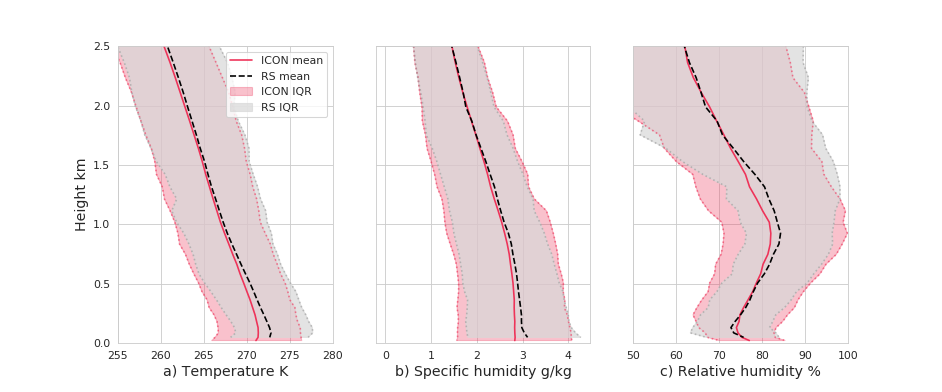

(0, 2.5)

In [61]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,5))

# Temperature
ax1.plot(t_icon_mean, temp_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax1.fill_betweenx(temp_meteogram.height_2/1000, t_icon_q1, t_icon_q2, 
                  color="#EE3359", alpha=0.3, label = "ICON IQR")
ax1.plot(t_icon_q1, temp_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax1.plot(t_icon_q2, temp_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax1.plot(t_rs_mean, temp_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax1.fill_betweenx(temp_meteogram.height_2/1000, t_rs_q1, t_rs_q2, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax1.plot(t_rs_q1, temp_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax1.plot(t_rs_q2, temp_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax1.set_xlabel("a) Temperature K", fontsize=13)
ax1.set_xlim(255,280)
ax1.set_ylim(0,2.5)
ax1.legend(loc='upper right')
ax1.set_ylabel("Height km", fontsize=13)

# Specific humidity
ax2.plot(q_icon_mean*1000, q_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax2.fill_betweenx(q_meteogram.height_2/1000, q_icon_q1*1000, q_icon_q2*1000, 
                  color="#EE3359", alpha=0.3)
ax2.plot(q_icon_q1*1000, q_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax2.plot(q_icon_q2*1000, q_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax2.plot(q_rs_mean*1000, q_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax2.fill_betweenx(q_meteogram.height_2/1000, q_rs_q1*1000, q_rs_q2*1000, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax2.plot(q_rs_q1*1000, q_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax2.plot(q_rs_q2*1000, q_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax2.set_xlabel("b) Specific humidity g/kg", fontsize=13)
ax2.yaxis.set_ticklabels([])
ax2.set_ylim(0,2.5)

# Relative humidity
ax3.plot(rh_icon_mean, rh_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax3.fill_betweenx(rh_meteogram.height_2/1000, rh_icon_q1, rh_icon_q2, 
                  color="#EE3359", alpha=0.3, label = "ICON IQR")
ax3.plot(rh_icon_q1, rh_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6, label = "ICON IQR")
ax3.plot(rh_icon_q2, rh_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6, label = "ICON IQR")
ax3.plot(rh_rs_mean, rh_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax3.fill_betweenx(rh_meteogram.height_2/1000, rh_rs_q1, rh_rs_q2, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax3.plot(rh_rs_q1, rh_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6,label = "RS IQR")
ax3.plot(rh_rs_q2, rh_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6, label = "RS IQR")
ax3.set_xlabel("c) Relative humidity %", fontsize=13)
ax3.yaxis.set_ticklabels([])
ax3.set_xlim(50,100)
ax3.set_ylim(0,2.5)

<IPython.core.display.Javascript object>


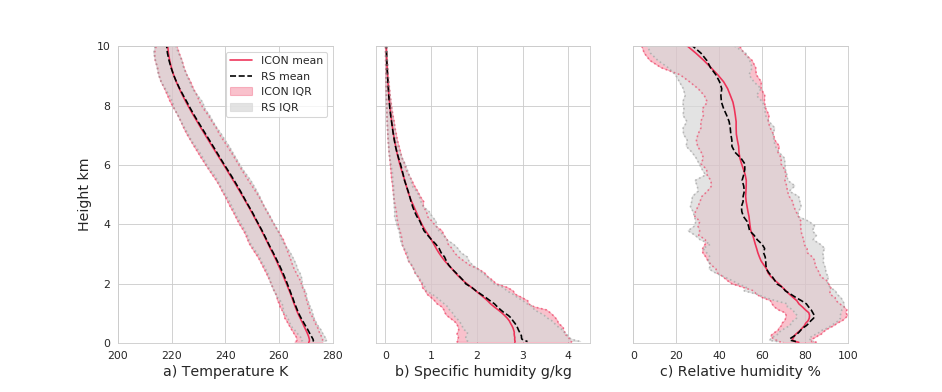

In [66]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,5))

# Temperature
ax1.plot(t_icon_mean, temp_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax1.fill_betweenx(temp_meteogram.height_2/1000, t_icon_q1, t_icon_q2, 
                  color="#EE3359", alpha=0.3, label = "ICON IQR")
ax1.plot(t_icon_q1, temp_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax1.plot(t_icon_q2, temp_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax1.plot(t_rs_mean, temp_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax1.fill_betweenx(temp_meteogram.height_2/1000, t_rs_q1, t_rs_q2, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax1.plot(t_rs_q1, temp_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax1.plot(t_rs_q2, temp_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax1.set_xlabel("a) Temperature K", fontsize=13)
ax1.set_xlim(200,280)
ax1.set_ylim(0,10)
ax1.legend(loc='upper right')
ax1.set_ylabel("Height km", fontsize=13)

# Specific humidity
ax2.plot(q_icon_mean*1000, q_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax2.fill_betweenx(q_meteogram.height_2/1000, q_icon_q1*1000, q_icon_q2*1000, 
                  color="#EE3359", alpha=0.3)
ax2.plot(q_icon_q1*1000, q_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax2.plot(q_icon_q2*1000, q_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6)
ax2.plot(q_rs_mean*1000, q_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax2.fill_betweenx(q_meteogram.height_2/1000, q_rs_q1*1000, q_rs_q2*1000, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax2.plot(q_rs_q1*1000, q_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax2.plot(q_rs_q2*1000, q_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6)
ax2.set_xlabel("b) Specific humidity g/kg", fontsize=13)
ax2.yaxis.set_ticklabels([])
ax2.set_ylim(0,10)

# Relative humidity
ax3.plot(rh_icon_mean, rh_meteogram.height_2/1000, color="#EE3359", label = "ICON mean")
ax3.fill_betweenx(rh_meteogram.height_2/1000, rh_icon_q1, rh_icon_q2, 
                  color="#EE3359", alpha=0.3, label = "ICON IQR")
ax3.plot(rh_icon_q1, rh_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6, label = "ICON IQR")
ax3.plot(rh_icon_q2, rh_meteogram.height_2/1000, linestyle="dotted", 
                  color="#EE3359", alpha=0.6, label = "ICON IQR")
ax3.plot(rh_rs_mean, rh_meteogram.height_2/1000, color="#000000", linestyle="dashed", label = "RS mean")
ax3.fill_betweenx(rh_meteogram.height_2/1000, rh_rs_q1, rh_rs_q2, 
                  color="#d8d8d8", alpha=0.7, label = "RS IQR")
ax3.plot(rh_rs_q1, rh_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6,label = "RS IQR")
ax3.plot(rh_rs_q2, rh_meteogram.height_2/1000, linestyle="dotted",
                  color="#999999", alpha=0.6, label = "RS IQR")
ax3.set_xlabel("c) Relative humidity %", fontsize=13)
ax3.yaxis.set_ticklabels([])
ax3.set_xlim(0,100)
ax3.set_ylim(0,10)

#plt.savefig("Fig_4_supplement_profiles_upto10km.png", bbox_inches="tight", dpi=300, format="png")